<a href="https://colab.research.google.com/github/Vaibhavi-Sita/EasyFirstAid/blob/main/TF_IDF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip3 install -r requirements.txt

ERROR: Operation cancelled by user


In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import pandas as pd

file_path = "./data/firstaid_train_contents.jsonl.txt"
texts = []

with open(file_path, "r") as f:
    for line in f:
        obj = json.loads(line)
        try:
            question = obj["contents"][0]["parts"][0]["text"]
            texts.append(question)
        except (KeyError, IndexError):
            continue

# TF-IDF vectorization
vectorizer = TfidfVectorizer(stop_words="english", max_features=1000)
tfidf_matrix = vectorizer.fit_transform(texts)

# Get top terms based on average tf-idf score
avg_tfidf_scores = tfidf_matrix.mean(axis=0).A1
terms = vectorizer.get_feature_names_out()
top_terms = sorted(zip(terms, avg_tfidf_scores), key=lambda x: x[1], reverse=True)[:30]

# Create a DataFrame for display
top_terms_df = pd.DataFrame(top_terms, columns=["Term", "Average TF-IDF Score"])

print(top_terms_df.head(30))


           Term  Average TF-IDF Score
0           aid              0.065114
1       respond              0.052488
2          help              0.047715
3         steps              0.042507
4         treat              0.039985
5        person              0.034453
6          bite              0.033972
7        manage              0.029525
8           arm              0.027600
9          burn              0.025008
10         head              0.021952
11     bleeding              0.021635
12        fever              0.021543
13       attack              0.018965
14       severe              0.018956
15  overheating              0.017958
16         care              0.017861
17     symptoms              0.017685
18       handle              0.017489
19    frostbite              0.017306
20       broken              0.016802
21        chest              0.016258
22       reduce              0.015782
23        shows              0.015560
24          leg              0.015521
25         h

In [10]:
from sklearn.cluster import KMeans

# Use KMeans to cluster into 20 groups
num_clusters = 20
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(tfidf_matrix)

# Get top terms per cluster
terms = vectorizer.get_feature_names_out()
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]

cluster_keywords = {}
for i in range(num_clusters):
    top_words = [terms[ind] for ind in order_centroids[i, :10]]
    cluster_keywords[f"Cluster {i}"] = top_words

# Assign cluster to each question
clustered_df = pd.DataFrame({"question": texts, "cluster": kmeans.labels_})

cluster_keywords


{'Cluster 0': ['attack',
  'symptoms',
  'heart',
  'asthma',
  'stroke',
  'having',
  'possible',
  'respond',
  'person',
  'shows'],
 'Cluster 1': ['steps',
  'aid',
  'heat',
  'overheating',
  'exhaustion',
  'fatigue',
  'hypothermia',
  'heatstroke',
  'working',
  'treat'],
 'Cluster 2': ['care',
  'bruise',
  'arm',
  'scrape',
  'small',
  'cut',
  'aid',
  'exposure',
  'fever',
  'fatigue'],
 'Cluster 3': ['arm',
  'bleeding',
  'weakness',
  'heavy',
  'shows',
  'broken',
  'respond',
  'steps',
  'stop',
  'electric'],
 'Cluster 4': ['treat',
  'consciousness',
  'loses',
  'faints',
  'seizure',
  'overheating',
  'ingested',
  'chemicals',
  'household',
  'burn'],
 'Cluster 5': ['choking',
  'candy',
  'help',
  'aid',
  'wrist',
  'experiencing',
  'fatigue',
  'faints',
  'facial',
  'extreme'],
 'Cluster 6': ['fever',
  'unexplained',
  'reduce',
  'high',
  'discomfort',
  'drooping',
  'electric',
  'electrical',
  'electrocution',
  'dehydration'],
 'Cluster 7'

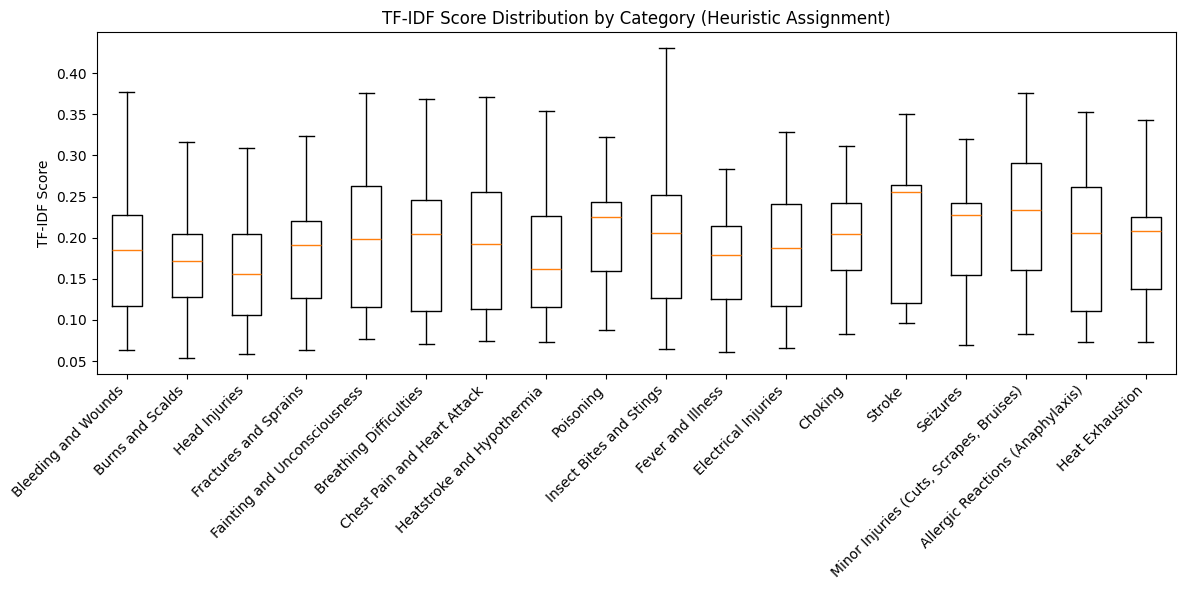

In [13]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_json('./data/firstaid_train_contents.jsonl.txt', lines=True)

# Extract combined user questions and assistant answers
combined_texts = []
question_texts = []
for entry in df['contents']:
    user_text = []
    all_text = []
    for msg in entry:
        for part in msg.get('parts', []):
            text = part.get('text', '').strip()
            all_text.append(text)
            if msg.get('role') == 'user':
                user_text.append(text.lower())
    combined_texts.append(" ".join(all_text))
    question_texts.append(" ".join(user_text))

# Define category keywords for heuristic assignment
category_keywords = {
    "Bleeding and Wounds": ["bleed", "wound", "cut", "bruise"],
    "Burns and Scalds": ["burn", "scald"],
    "Head Injuries": ["head", "concussion"],
    "Fractures and Sprains": ["fracture", "sprain"],
    "Fainting and Unconsciousness": ["faint", "unconscious"],
    "Breathing Difficulties": ["breath", "asphyxiation", "choke"],
    "Chest Pain and Heart Attack": ["chest", "heart", "attack", "aspirin"],
    "Heatstroke and Hypothermia": ["heatstroke", "hypothermia"],
    "Poisoning": ["poison"],
    "Insect Bites and Stings": ["bite", "sting", "mosquito"],
    "Fever and Illness": ["fever", "illness"],
    "Electrical Injuries": ["electric", "electric shock"],
    "Choking": ["choking", "choke"],
    "Stroke": ["stroke"],
    "Seizures": ["seizure"],
    "Minor Injuries (Cuts, Scrapes, Bruises)": ["scrape", "abrasion"],
    "Allergic Reactions (Anaphylaxis)": ["allerg", "anaphylaxis"],
    "Heat Exhaustion": ["heat exhaustion"],
    "Frostbite": ["frostbite"],
    "Snake Bites": ["snake"]
}

# Assign categories heuristically
categories = []
for q in question_texts:
    assigned = "Other"
    for cat, keywords in category_keywords.items():
        if any(kw in q for kw in keywords):
            assigned = cat
            break
    categories.append(assigned)

# Compute TF-IDF matrix
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(combined_texts).toarray()

# Group TF-IDF values by category (non-zero)
category_distributions = []
labels = []
for cat in category_keywords.keys():
    idx = [i for i, c in enumerate(categories) if c == cat]
    if not idx:
        continue
    # Extract rows for category and flatten non-zero values
    vals = tfidf_matrix[idx, :].flatten()
    non_zero_vals = vals[vals > 0]
    category_distributions.append(non_zero_vals)
    labels.append(cat)

# Plot boxplot of TF-IDF distributions per category
plt.figure(figsize=(12, 6))
plt.boxplot(category_distributions, labels=labels, showfliers=False)
plt.xticks(rotation=45, ha='right')
plt.ylabel('TF-IDF Score')
plt.title('TF-IDF Score Distribution by Category (Heuristic Assignment)')
plt.tight_layout()
plt.show()
